In [6]:
from snv import *
import os
import glob
import pandas as pd
from helper import *


In [7]:
errors = np.zeros([100, 3, 2])

In [ ]:
%%capture
for kk in range(100):
    !python clipp_data_simulation.py
    df = pd.read_csv('/Users/yuding/Dropbox/GitHub/Multi_Region_CliPP/multi_clipp_simulation_data/simulation_data_cluster_5_region_1_read_depth_100_replica_2.tsv', sep='\t')
    true_clonal_fraction = df['cluster'].value_counts(normalize=True)[0]
    true_cp = df['cp'].to_list()
    true_num_clusters = len(df['cluster'].unique())

    df1 = df[['mutation', 'ref_counts', 'alt_counts']].copy()
    df1['alt_counts'] = df1['alt_counts'].replace(0, 1)
    df1['mutation'] = [1 for i in range(1, len(df1) + 1)]
    df1.rename(columns={
        'ref_counts': 'ref_count',
        'alt_counts': 'alt_count'
    }, inplace=True)
    df1.rename(columns={'mutation': 'chromosome_index'}, inplace=True)
    df1['position'] = [5 * i + 2 for i in range(1, len(df1) + 1)]
    df1 = df1[['chromosome_index', 'position', 'alt_count', 'ref_count']]
    df1.to_csv('sample_snv.txt', sep='\t', index=False)

    # Create df2 with mutation, major_cn, minor_cn, and sum_cn
    df2 = df[['mutation', 'major_cn', 'minor_cn']].copy()
    df2['mutation'] =[1 for i in range(1, len(df2) + 1)]
    df2['total_cn'] = df2['major_cn'] + df2['minor_cn']
    df2.rename(columns={'mutation': 'chromosome_index'}, inplace=True)
    df2['start_position'] = [5 * i + 1 for i in range(1, len(df2) + 1)]
    df2['end_position'] = [5 * i + 4 for i in range(1, len(df2) + 1)]
    df2 = df2[['chromosome_index', 'start_position', 'end_position', 'major_cn', 'minor_cn', 'total_cn']]

    df2.to_csv('sample_cna.txt', sep='\t', index=False)

    # Get the first element of the 'tumour_purity' column
    purity = df['tumour_purity'].iloc[0]

    # Open a file in write mode and save the number
    with open('sample_purity.txt', 'w') as file:
        file.write(str(purity))
        
    !docker run -v $(pwd):/Sample clipp python3 /CliPP/run_clipp_main.py -i /Sample/test /Sample/sample_snv.txt /Sample/sample_cna.txt /Sample/sample_purity.txt

    file = glob.glob('test/final_result/Best_lambda/*mutation_assignments*')
    df = pd.read_csv(file[0], sep='\t')
    cluster_index = df['cluster_index'].values
    estimated_num_clusters = len(np.unique(cluster_index))

    file = glob.glob('test/final_result/Best_lambda/*subclonal_structure*')
    df = pd.read_csv(file[0], sep='\t')
    estimated_clonal_fraction = df['num_SNV'][0] / df['num_SNV'].sum()
    estimated_cp = []
    for i in range(len(cluster_index)):
        estimated_cp.append(df['cellular_prevalence'][cluster_index[i]])
        
    try:
        errors[kk, :, 0] = reNC(estimated_num_clusters, true_num_clusters), rdCF(estimated_clonal_fraction, true_clonal_fraction), RMSE(estimated_cp, true_cp, purity)
    except:
        continue
    shutil.rmtree('test')
    
    df = pd.read_csv('/Users/yuding/Dropbox/GitHub/Multi_Region_CliPP/multi_clipp_simulation_data/simulation_data_cluster_5_region_1_read_depth_100_replica_2.tsv', sep='\t')
    rho = 0.2
    omega = 1
    n = df.shape[0]
    m = 1
    max_iteration = 20
    gamma = [0.02 * i for i in range(14)]
    ray.shutdown()
    ray.init(ignore_reinit_error=True)
    res0 = [ADMM.remote(df, rho, gamma[i], omega, n, m, max_iteration) for i in range(14)]
    res0 = ray.get(res0)
    ray.shutdown()
    best_res = find_gamma_single_region(res0, purity, n, m)
    estimated_cp = [i for [i] in convert_p_to_cp(best_res[0], n, m).tolist()]
    estimated_num_clusters = len(np.unique(best_res[7]))
    df_res = pd.DataFrame(
            {'cluster_index': best_res[7],
            'cp' : estimated_cp
            }
        )
    estimated_clonal_fraction =  df_res['cluster_index'].value_counts(normalize=True)[df_res.groupby('cluster_index')['cp'].mean().idxmax()]
    errors[kk, :, 1] = reNC(estimated_num_clusters, true_num_clusters), rdCF(estimated_clonal_fraction, true_clonal_fraction), RMSE(estimated_cp, true_cp, purity)
    
    # temp = np.zeros([14, 3])
    # for i in range(14):
    #     estimated_cp = [i for [i] in convert_p_to_cp(res0[i][0], n, m).tolist()]
    #     estimated_num_clusters = len(np.unique(res0[i][7]))
    #     df_res = pd.DataFrame(
    #         {'cluster_index': res0[i][7],
    #         'cp' : [i for [i] in convert_p_to_cp(res0[i][0], n, m).tolist()]
    #         }
    #     )
    #     estimated_clonal_fraction =  df_res['cluster_index'].value_counts(normalize=True)[df_res.groupby('cluster_index')['cp'].mean().idxmax()]
    #     temp[i,:] = reNC(estimated_num_clusters, true_num_clusters), rdCF(estimated_clonal_fraction, true_clonal_fraction), RMSE(estimated_cp, true_cp, purity)
    # maxi = np.argmin(np.sum(temp, axis=1))
    
    # errors[kk, :, 1] = temp[maxi, :]

2025-01-21 11:15:06,185	INFO worker.py:1786 -- Started a local Ray instance.
2025-01-21 11:15:19,422	INFO worker.py:1786 -- Started a local Ray instance.
2025-01-21 11:15:32,290	INFO worker.py:1786 -- Started a local Ray instance.
2025-01-21 11:15:45,846	INFO worker.py:1786 -- Started a local Ray instance.
2025-01-21 11:15:59,189	INFO worker.py:1786 -- Started a local Ray instance.
2025-01-21 11:16:12,647	INFO worker.py:1786 -- Started a local Ray instance.
2025-01-21 11:16:26,116	INFO worker.py:1786 -- Started a local Ray instance.
2025-01-21 11:16:39,495	INFO worker.py:1786 -- Started a local Ray instance.


In [14]:
errors
np.sum(errors, 0)

array([[ 25.8       ,  14.8       ],
       [108.27508567,  68.84838821],
       [ 22.07571449,  19.54133936]])

/var/folders/w9/kx7wk6017tl5yqsllw_f5hph0000gn/T/ipykernel_69522/1853659581.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='Model', y='reNC', data=df_melted, palette=['#1f77b4', '#ff7f0e'])
/var/folders/w9/kx7wk6017tl5yqsllw_f5hph0000gn/T/ipykernel_69522/1853659581.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_values = df_melted.groupby('Model')['reNC'].mean()


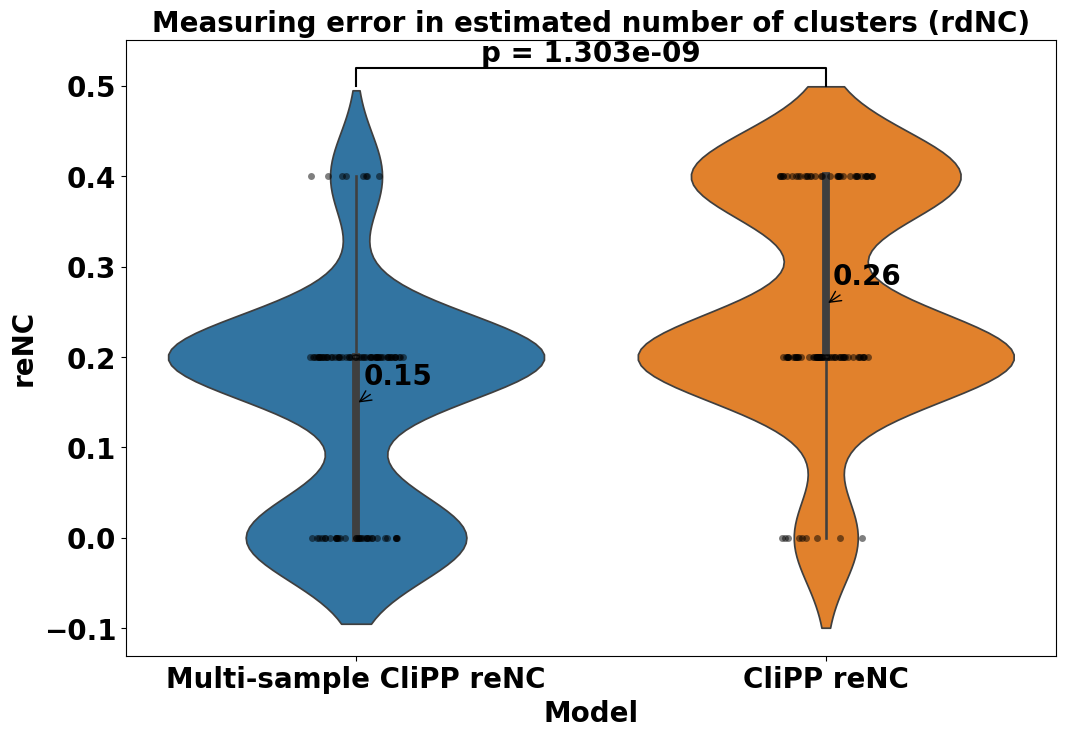

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import pandas as pd

# Extract the data for the second dimension
data0 = [errors[:, i, 0] for i in range(3)]
data1 = [errors[:, i, 1] for i in range(3)]

# Create a DataFrame for plotting
df = pd.DataFrame({
    'Multi-sample CliPP reNC': data1[0],
    'CliPP reNC': data0[0],
})

# Melt the DataFrame for seaborn
df_melted = df.melt(var_name='Model', value_name='reNC')

# Reorder the categories
df_melted['Model'] = pd.Categorical(df_melted['Model'], categories=['Multi-sample CliPP reNC', 'CliPP reNC'])

# Create the violin plots
plt.figure(figsize=(12, 8))
ax = sns.violinplot(x='Model', y='reNC', data=df_melted, palette=['#1f77b4', '#ff7f0e'])

# Overlay the individual data points
sns.stripplot(x='Model', y='reNC', data=df_melted, color='k', alpha=0.5)

# Calculate and annotate the mean values with arrows
mean_values = df_melted.groupby('Model')['reNC'].mean()
for i, mean in enumerate(mean_values):
    ax.annotate(f'{mean:.2f}', xy=(i, mean), xycoords='data',
                xytext=(30, 10), textcoords='offset points',
                arrowprops=dict(arrowstyle='->', color='black'),
                ha='center', va='bottom', color='black', fontsize=20, fontweight='bold')

# Perform significance test
t_stat, p_val = ttest_ind(data0[0], data1[0])

# Annotate the plot with the p-value
x1, x2 = 0, 1
y, h, col = df_melted['reNC'].max() + 0.1, 0.02, 'k'
ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
ax.text((x1 + x2) * .5, y + h, f"p = {p_val:.3e}", ha='center', va='bottom', color=col, fontsize=20, fontweight='bold')

# Set larger font sizes for title and labels
plt.title('Measuring error in estimated number of clusters (rdNC)', fontsize=20, fontweight='bold')
plt.xlabel('Model', fontsize=20, fontweight='bold')
plt.ylabel('reNC', fontsize=20, fontweight='bold')
plt.xticks(fontsize=20, fontweight='bold')
plt.yticks(fontsize=20, fontweight='bold')

plt.show()

/var/folders/w9/kx7wk6017tl5yqsllw_f5hph0000gn/T/ipykernel_69522/2051369080.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='Model', y='reCF', data=df_melted, palette=['#1f77b4', '#ff7f0e'])
/var/folders/w9/kx7wk6017tl5yqsllw_f5hph0000gn/T/ipykernel_69522/2051369080.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_values = df_melted.groupby('Model')['reCF'].mean()


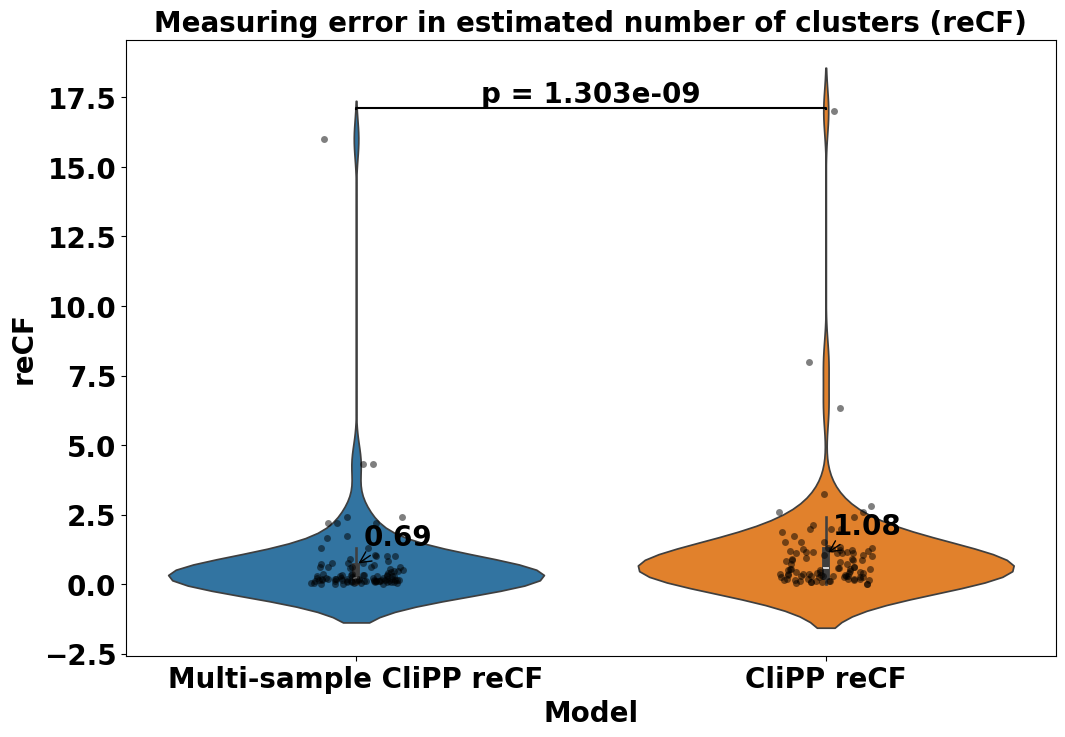

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import pandas as pd

# Extract the data for the second dimension
data0 = [errors[:, i, 0] for i in range(3)]
data1 = [errors[:, i, 1] for i in range(3)]

# Create a DataFrame for plotting
df = pd.DataFrame({
    'Multi-sample CliPP reCF': data1[1],
    'CliPP reCF': data0[1],
})

# Melt the DataFrame for seaborn
df_melted = df.melt(var_name='Model', value_name='reCF')

# Reorder the categories
df_melted['Model'] = pd.Categorical(df_melted['Model'], categories=['Multi-sample CliPP reCF', 'CliPP reCF'])

# Create the violin plots
plt.figure(figsize=(12, 8))
ax = sns.violinplot(x='Model', y='reCF', data=df_melted, palette=['#1f77b4', '#ff7f0e'])

# Overlay the individual data points
sns.stripplot(x='Model', y='reCF', data=df_melted, color='k', alpha=0.5)

# Calculate and annotate the mean values with arrows
mean_values = df_melted.groupby('Model')['reCF'].mean()
for i, mean in enumerate(mean_values):
    ax.annotate(f'{mean:.2f}', xy=(i, mean), xycoords='data',
                xytext=(30, 10), textcoords='offset points',
                arrowprops=dict(arrowstyle='->', color='black'),
                ha='center', va='bottom', color='black', fontsize=20, fontweight='bold')

# Perform significance test
t_stat, p_val = ttest_ind(data0[0], data1[0])

# Annotate the plot with the p-value
x1, x2 = 0, 1
y, h, col = df_melted['reCF'].max() + 0.1, 0.02, 'k'
ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
ax.text((x1 + x2) * .5, y + h, f"p = {p_val:.3e}", ha='center', va='bottom', color=col, fontsize=20, fontweight='bold')

# Set larger font sizes for title and labels
plt.title('Measuring error in estimated number of clusters (reCF)', fontsize=20, fontweight='bold')
plt.xlabel('Model', fontsize=20, fontweight='bold')
plt.ylabel('reCF', fontsize=20, fontweight='bold')
plt.xticks(fontsize=20, fontweight='bold')
plt.yticks(fontsize=20, fontweight='bold')

plt.show()

/var/folders/w9/kx7wk6017tl5yqsllw_f5hph0000gn/T/ipykernel_69522/1885584873.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='Model', y='RMSE', data=df_melted, palette=['#1f77b4', '#ff7f0e'])
/var/folders/w9/kx7wk6017tl5yqsllw_f5hph0000gn/T/ipykernel_69522/1885584873.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_values = df_melted.groupby('Model')['RMSE'].mean()


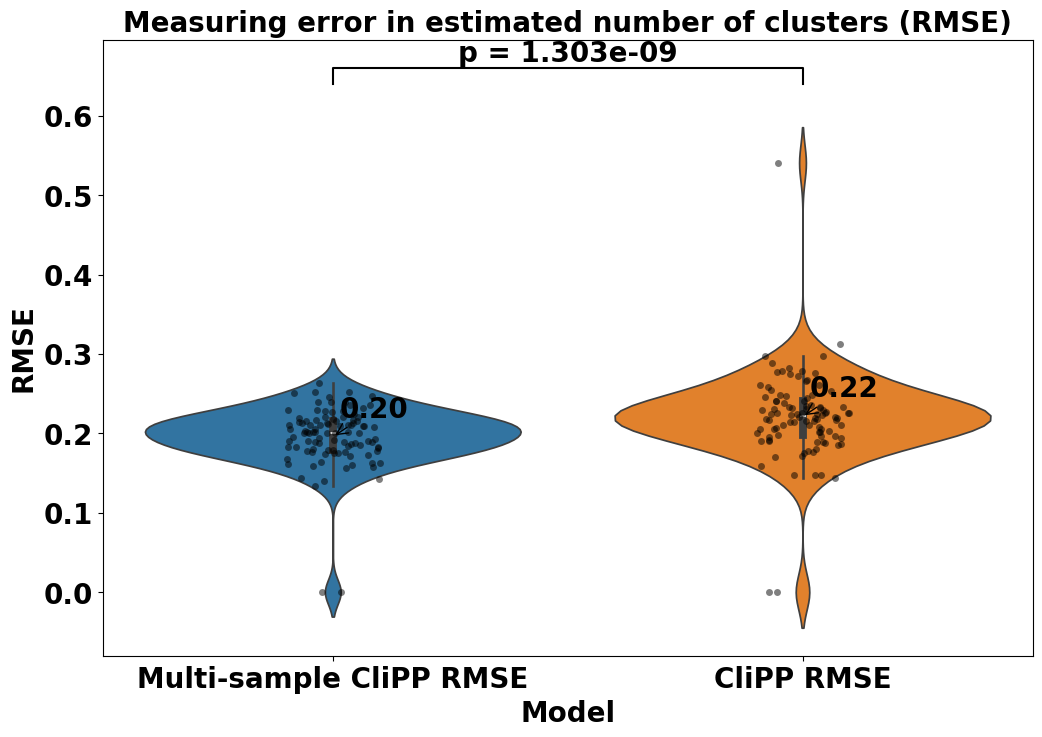

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import pandas as pd

# Extract the data for the second dimension
data0 = [errors[:, i, 0] for i in range(3)]
data1 = [errors[:, i, 1] for i in range(3)]

# Create a DataFrame for plotting
df = pd.DataFrame({
    'Multi-sample CliPP RMSE': data1[2],
    'CliPP RMSE': data0[2],
})

# Melt the DataFrame for seaborn
df_melted = df.melt(var_name='Model', value_name='RMSE')

# Reorder the categories
df_melted['Model'] = pd.Categorical(df_melted['Model'], categories=['Multi-sample CliPP RMSE', 'CliPP RMSE'])

# Create the violin plots
plt.figure(figsize=(12, 8))
ax = sns.violinplot(x='Model', y='RMSE', data=df_melted, palette=['#1f77b4', '#ff7f0e'])

# Overlay the individual data points
sns.stripplot(x='Model', y='RMSE', data=df_melted, color='k', alpha=0.5)

# Calculate and annotate the mean values with arrows
mean_values = df_melted.groupby('Model')['RMSE'].mean()
for i, mean in enumerate(mean_values):
    ax.annotate(f'{mean:.2f}', xy=(i, mean), xycoords='data',
                xytext=(30, 10), textcoords='offset points',
                arrowprops=dict(arrowstyle='->', color='black'),
                ha='center', va='bottom', color='black', fontsize=20, fontweight='bold')

# Perform significance test
t_stat, p_val = ttest_ind(data0[0], data1[0])

# Annotate the plot with the p-value
x1, x2 = 0, 1
y, h, col = df_melted['RMSE'].max() + 0.1, 0.02, 'k'
ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
ax.text((x1 + x2) * .5, y + h, f"p = {p_val:.3e}", ha='center', va='bottom', color=col, fontsize=20, fontweight='bold')

# Set larger font sizes for title and labels
plt.title('Measuring error in estimated number of clusters (RMSE)', fontsize=20, fontweight='bold')
plt.xlabel('Model', fontsize=20, fontweight='bold')
plt.ylabel('RMSE', fontsize=20, fontweight='bold')
plt.xticks(fontsize=20, fontweight='bold')
plt.yticks(fontsize=20, fontweight='bold')

plt.show()

In [9]:
from snv import *
import os
import glob
import pandas as pd
from helper import *
filepath = '/Users/yuding/Downloads/CliPP_sim4k_input'

In [10]:
import os

def get_all_subdirectories(directory):
    subdirectories = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    return subdirectories

def get_all_subfiles(directory):
    subfiles = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            subfiles.append(os.path.join(root, file))
    return subfiles

# Example usage
filepath = '/Users/yuding/Downloads/CliPP_sim4k_input/'
all_subdir = get_all_subdirectories(filepath)
# Path to the text file
file_path = 'data1.txt'
# Read every line in the file
with open(file_path, 'r') as file:
    lines = file.readlines()

# Print each line
for line in lines:
    done_subdir = line.split(' #')[0]
    if done_subdir in all_subdir:
        all_subdir.remove(done_subdir)
        # print(done_subdir)

In [ ]:
%%capture
for subdir in all_subdir:
    files = get_all_subfiles(filepath + subdir)
    for file in files:
        if 'cna.txt' in file:
            cnafile = file
        elif 'snv.txt' in file:
            snvfile = file
        elif 'purity.txt' in file:
            purityfile = file
        else:
            stop(f"This file {file} should not be here.")
    df = create_df_from_clipp(snvfile, cnafile, purityfile)
    purity = df['tumour_purity'].iloc[0]
    rho = 0.3
    omega = 1
    n = df.shape[0]
    m = 1
    max_iteration = 5
    gamma = [0.02 * i for i in range(14)]
    ray.shutdown()
    ray.init()
    res0 = [ADMM.remote(df, rho, gamma[i], omega, n, m, max_iteration) for i in range(14)]
    res0 = ray.get(res0)
    ray.shutdown()
    best_res = find_gamma_single_region(res0, purity, n, m)
    # estimated_cp = [i for [i] in convert_p_to_cp(best_res[0], n, m).tolist()]
    estimated_num_clusters = len(np.unique(best_res[7]))
    df_res = pd.DataFrame(
            {'cluster_index': best_res[7],
            'cp' : [i for [i] in convert_p_to_cp(best_res[0], n, m).tolist()]
            }
        )
    estimated_clonal_fraction =  df_res['cluster_index'].value_counts(normalize=True)[df_res.groupby('cluster_index')['cp'].mean().idxmax()]
    with open('data1.txt', 'a') as f:
        f.write(subdir + " # " + 'estimated_clonal_fraction : [' + str(estimated_clonal_fraction) + "] estimated_num_clusters : [" + str(estimated_num_clusters) + ']\n')

    
        

2025-01-13 21:42:51,280	INFO worker.py:1786 -- Started a local Ray instance.
2025-01-13 21:44:35,365	INFO worker.py:1786 -- Started a local Ray instance.
2025-01-13 21:47:17,946	INFO worker.py:1786 -- Started a local Ray instance.
2025-01-13 21:50:14,949	INFO worker.py:1786 -- Started a local Ray instance.
2025-01-13 21:51:42,697	INFO worker.py:1786 -- Started a local Ray instance.
2025-01-13 21:52:34,927	INFO worker.py:1786 -- Started a local Ray instance.
2025-01-13 21:55:36,003	INFO worker.py:1786 -- Started a local Ray instance.
2025-01-13 21:57:03,321	INFO worker.py:1786 -- Started a local Ray instance.
2025-01-13 22:00:15,247	INFO worker.py:1786 -- Started a local Ray instance.
2025-01-13 22:01:01,600	INFO worker.py:1786 -- Started a local Ray instance.
2025-01-13 22:04:14,100	INFO worker.py:1786 -- Started a local Ray instance.
2025-01-13 22:06:35,931	INFO worker.py:1786 -- Started a local Ray instance.
2025-01-13 22:07:19,615	INFO worker.py:1786 -- Started a local Ray instance.

In [18]:
import pandas as pd

In [19]:
import re
done_subdir = []
estimated_clonal_fractions = []
estimated_num_clusters_lst = []
df = pd.DataFrame()
pattern = r"estimated_clonal_fraction\s*:\s*\[([0-9.]+)\].*estimated_num_clusters\s*:\s*\[([0-9]+)\]"
with open('data1.txt', 'r') as file:
    lines = file.readlines()
for line in lines:
    done_subdir.append(line.split(' #')[0])
    match = re.search(pattern, line)
    if match:
        estimated_clonal_fraction = float(match.group(1))
        estimated_num_clusters = int(match.group(2))
        estimated_clonal_fractions.append(estimated_clonal_fraction)    
        estimated_num_clusters_lst.append(estimated_num_clusters)
        print(line.split(' #')[0])
        print(f"Estimated Clonal Fraction: {estimated_clonal_fraction}")
        print(f"Estimated Number of Clusters: {estimated_num_clusters}")

1000_3_30_0_rep4
Estimated Clonal Fraction: 0.3142857142857143
Estimated Number of Clusters: 2
100_2_60_20_rep39
Estimated Clonal Fraction: 0.5462633451957295
Estimated Number of Clusters: 2
100_3_30_0_rep47
Estimated Clonal Fraction: 0.3324905183312263
Estimated Number of Clusters: 2
1000_3_60_10_rep48
Estimated Clonal Fraction: 0.3433208489388265
Estimated Number of Clusters: 3
100_4_60_10_rep28
Estimated Clonal Fraction: 0.43923444976076553
Estimated Number of Clusters: 2
100_2_60_0_rep38
Estimated Clonal Fraction: 0.475
Estimated Number of Clusters: 2
500_3_30_10_rep40
Estimated Clonal Fraction: 0.37359900373599003
Estimated Number of Clusters: 2
1000_4_90_20_rep2
Estimated Clonal Fraction: 1.0
Estimated Number of Clusters: 1
100_4_30_10_rep39
Estimated Clonal Fraction: 0.3007662835249042
Estimated Number of Clusters: 2
100_2_30_20_rep28
Estimated Clonal Fraction: 0.5476673427991886
Estimated Number of Clusters: 2
1000_2_60_0_rep28
Estimated Clonal Fraction: 0.5102040816326531
Esti

In [20]:
df = pd.read_excel('/Users/yuding/Downloads/CliPP_PhyloWGS_CliPPSim4k.xlsx')

In [21]:
df

,Sample,Truth_nCluster,purity,CNA_rate,read_depth,Truth_Clonal_SNV,Truth_Total_SNV,Truth_Clonal_Fraction,CliPP_nCluster,CliPP_Clonal_SNV,...,CliPP_rdNC,CliPP_rdCF,CliPP_RMSE,PhyloWGS_nCluster,PhyloWGS_Clonal_SNV,PhyloWGS_Total_SNV,PhyloWGS_Clonal_Fraction,PhyloWGS_rdNC,PhyloWGS_rdCF,PhyloWGS_RMSE
0,100_2_30_0_rep0,2,Purity: 30,CNA Rate: 0,100,249,505,0.493069,2,246,...,0.00,0.008120,0.043266,2.0,256.0,505.0,0.506931,0.00,0.028112,0.062547
1,100_2_30_0_rep1,2,Purity: 30,CNA Rate: 0,100,250,524,0.477099,2,466,...,0.00,0.864000,0.162356,2.0,46.0,524.0,0.087786,0.00,0.816000,0.160131
2,100_2_30_0_rep10,2,Purity: 30,CNA Rate: 0,100,286,548,0.521898,2,295,...,0.00,0.031469,0.069664,2.0,287.0,548.0,0.523723,0.00,0.003497,0.023324
3,100_2_30_0_rep11,2,Purity: 30,CNA Rate: 0,100,217,459,0.472767,2,433,...,0.00,0.995392,0.133764,2.0,27.0,459.0,0.058824,0.00,0.875576,0.150531
4,100_2_30_0_rep12,2,Purity: 30,CNA Rate: 0,100,226,427,0.529274,2,298,...,0.00,0.318584,0.199908,2.0,231.0,427.0,0.540984,0.00,0.022124,0.060435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4045,500_4_90_20_rep5,4,Purity: 90,CNA Rate: 20,500,288,1063,0.270931,4,347,...,0.00,0.231507,0.091397,3.0,579.0,1063.0,0.544685,0.25,1.010417,0.114001
4046,500_4_90_20_rep6,4,Purity: 90,CNA Rate: 20,500,276,1007,0.274081,3,319,...,0.25,0.172092,0.101695,4.0,350.0,1007.0,0.347567,0.00,0.268116,0.109355
4047,500_4_90_20_rep7,4,Purity: 90,CNA Rate: 20,500,209,1002,0.208583,3,240,...,0.25,0.168144,0.114695,3.0,501.0,1002.0,0.500000,0.25,1.397129,0.109266
4048,500_4_90_20_rep8,4,Purity: 90,CNA Rate: 20,500,229,1035,0.221256,3,277,...,0.25,0.238322,0.108406,4.0,313.0,1035.0,0.302415,0.00,0.366812,0.112996


In [22]:
clipp_res_rdNC = []
clipp_res_rdCF = []
PhyloWGS_rdNC = []
PhyloWGS_rdCF = []
res_rdNC = []
res_rdCF = []

In [23]:
pattern = r'Purity:\s*(\d+)'

for i in range(len(done_subdir)):
    file = done_subdir[i]
    text = str(df.loc[df['Sample'] == file]['purity']) 
    match = re.search(pattern, text)
    purity = float(match.group(1)) / 100
    PhyloWGS_rdNC.append(df.loc[df['Sample'] == file]['PhyloWGS_rdNC'].values[0])
    PhyloWGS_rdCF.append(df.loc[df['Sample'] == file]['PhyloWGS_rdCF'].values[0])
    clipp_res_rdNC.append(df.loc[df['Sample'] == file]['CliPP_rdNC'].values[0])
    clipp_res_rdCF.append(df.loc[df['Sample'] == file]['CliPP_rdCF'].values[0])
    Truth_Clonal_Fraction = df.loc[df['Sample'] == file]['Truth_Clonal_Fraction'].values[0]
    Truth_nCluster = df.loc[df['Sample'] == file]['Truth_nCluster'].values[0]
    res_rdNC.append(reNC(estimated_num_clusters_lst[i], Truth_nCluster))
    res_rdCF.append(rdCF(estimated_clonal_fractions[i], Truth_Clonal_Fraction))


In [24]:
res_rdNC, res_rdCF

([0.3333333333333333,
  0.0,
  0.3333333333333333,
  0.0,
  0.5,
  0.0,
  0.3333333333333333,
  0.75,
  0.5,
  0.0,
  0.0,
  0.0,
  0.3333333333333333,
  0.3333333333333333,
  0.5,
  0.5,
  0.5,
  0.3333333333333333,
  0.0,
  0.0,
  0.0,
  0.5,
  0.6666666666666666,
  0.3333333333333333,
  0.6666666666666666,
  0.5,
  0.6666666666666666,
  0.0,
  0.75,
  0.6666666666666666,
  0.3333333333333333,
  0.3333333333333333,
  0.5,
  0.0,
  0.0,
  0.0,
  0.5,
  0.5,
  0.25,
  0.5,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.3333333333333333,
  0.5,
  0.6666666666666666,
  0.0,
  0.0,
  0.3333333333333333,
  0.5,
  0.75,
  0.6666666666666666,
  0.3333333333333333,
  0.6666666666666666,
  0.5,
  0.0,
  0.0,
  0.5,
  0.3333333333333333,
  0.6666666666666666,
  0.6666666666666666,
  0.0,
  0.6666666666666666,
  0.3333333333333333,
  0.5,
  0.75,
  0.5,
  0.0,
  0.0,
  0.75,
  0.6666666666666666,
  0.75,
  0.5,
  0.3333333333333333,
  0.5,
  0.75,
  0.0,
  0.0,
  0.3333333

/var/folders/w9/kx7wk6017tl5yqsllw_f5hph0000gn/T/ipykernel_69522/1426403049.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='Method', y='rdNC', data=df_melted, palette=['#1f77b4', '#ff7f0e', '#2ca02c'])


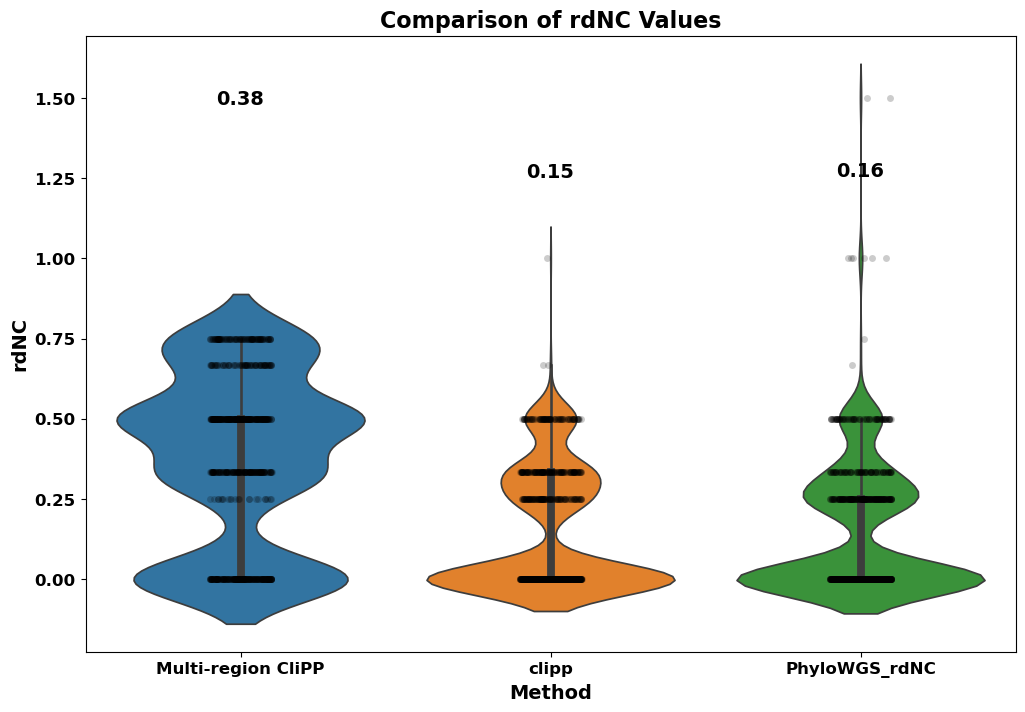

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Example data
data = {
    'Multi-region CliPP': res_rdNC,
    'clipp': clipp_res_rdNC,
    'PhyloWGS_rdNC': PhyloWGS_rdNC
}

# Create a DataFrame
df = pd.DataFrame(data)

# Melt the DataFrame for seaborn
df_melted = df.melt(var_name='Method', value_name='rdNC')

# Create the violin plot
plt.figure(figsize=(12, 8))
ax = sns.violinplot(x='Method', y='rdNC', data=df_melted, palette=['#1f77b4', '#ff7f0e', '#2ca02c'])
sns.stripplot(x='Method', y='rdNC', data=df_melted, color='k', alpha=0.2)

# Calculate and annotate the mean values
mean_values = df_melted.groupby('Method')['rdNC'].mean()
for i, mean in enumerate(mean_values):
    ax.annotate(f'{mean:.2f}', xy=(i, mean + 1), xycoords='data',
                xytext=(0, 20), textcoords='offset points',
                ha='center', va='bottom', color='black', fontsize=14, fontweight='bold')

# Set larger font sizes for title and labels
plt.title('Comparison of rdNC Values', fontsize=16, fontweight='bold')
plt.xlabel('Method', fontsize=14, fontweight='bold')
plt.ylabel('rdNC', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

plt.show()

/var/folders/w9/kx7wk6017tl5yqsllw_f5hph0000gn/T/ipykernel_69522/126272361.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='Method', y='rdCF', data=df_melted, palette=['#1f77b4', '#ff7f0e', '#2ca02c'])


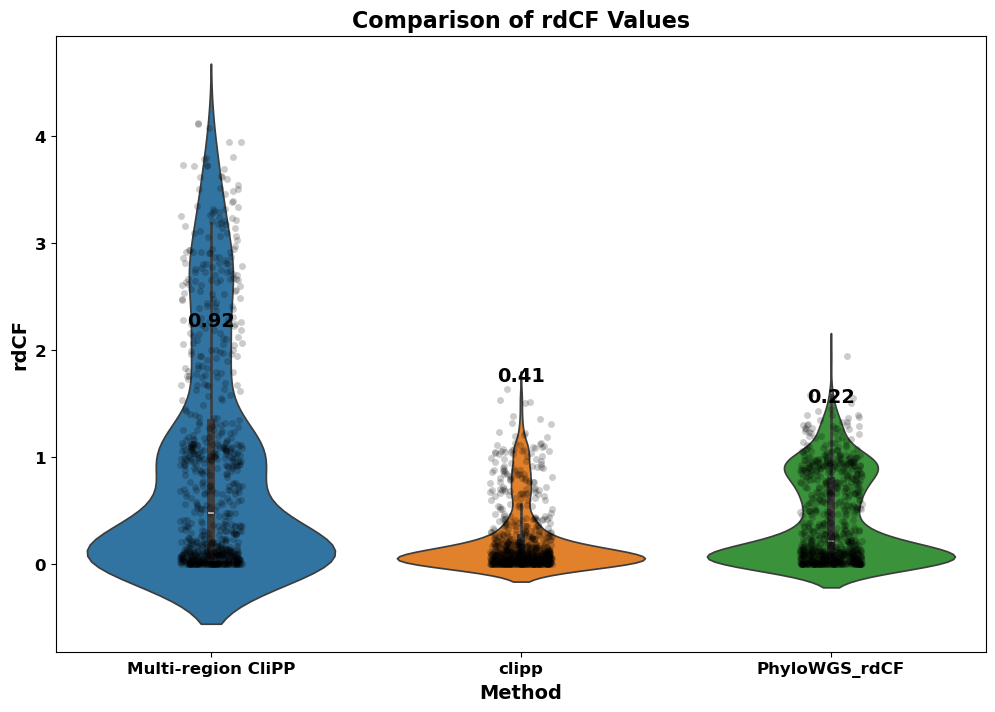

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Example data
data = {
    'Multi-region CliPP': res_rdCF,
    'clipp': clipp_res_rdCF,
    'PhyloWGS_rdCF': PhyloWGS_rdCF
}

# Create a DataFrame
df = pd.DataFrame(data)

# Melt the DataFrame for seaborn
df_melted = df.melt(var_name='Method', value_name='rdCF')

# Create the violin plot
plt.figure(figsize=(12, 8))
ax = sns.violinplot(x='Method', y='rdCF', data=df_melted, palette=['#1f77b4', '#ff7f0e', '#2ca02c'])
sns.stripplot(x='Method', y='rdCF', data=df_melted, color='k', alpha=0.2)

# Calculate and annotate the mean values
mean_values = df_melted.groupby('Method')['rdCF'].mean()
for i, mean in enumerate(mean_values):
    ax.annotate(f'{mean:.2f}', xy=(i, mean + 1), xycoords='data',
                xytext=(0, 20), textcoords='offset points',
                ha='center', va='bottom', color='black', fontsize=14, fontweight='bold')

# Set larger font sizes for title and labels
plt.title('Comparison of rdCF Values', fontsize=16, fontweight='bold')
plt.xlabel('Method', fontsize=14, fontweight='bold')
plt.ylabel('rdCF', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

plt.show()

In [8]:
from snv import *
import os
import glob
import pandas as pd
from helper import *
filepath = '/Users/yuding/Downloads/CliPP_sim4k_input/'
subdir = '100_2_90_20_rep35'

import os

def get_all_subdirectories(directory):
    subdirectories = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    return subdirectories

def get_all_subfiles(directory):
    subfiles = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            subfiles.append(os.path.join(root, file))
    return subfiles

In [2]:
files = get_all_subfiles(filepath + subdir)
for file in files:
    if 'cna.txt' in file:
        cnafile = file
    elif 'snv.txt' in file:
        snvfile = file
    elif 'purity.txt' in file:
        purityfile = file
df = create_df_from_clipp(snvfile, cnafile, purityfile)
purity = df['tumour_purity'].iloc[0]
rho = 0.3
omega = 1
n = df.shape[0]
m = 1
max_iteration = 10
gamma = [0.02 * i for i in range(14)]
ray.shutdown()
ray.init()
res0 = [ADMM.remote(df, rho, gamma[i], omega, n, m, max_iteration) for i in range(14)]
res0 = ray.get(res0)
ray.shutdown()
best_res = find_gamma_single_region(res0, purity, n, m)
# estimated_cp = [i for [i] in convert_p_to_cp(best_res[0], n, m).tolist()]
estimated_num_clusters = len(np.unique(best_res[7]))

2025-01-12 13:26:05,482	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=58380) Gamma: 0.08, clusters : dict_values([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [3]:
estimated_num_clusters

3

In [31]:
df1 = pd.read_csv("simulation_data_cluster_3_region_2_read_depth_100_replica_2.tsv", sep="\t")
change_df_to_pyclonevi(df1)
!pyclone-vi fit -i pyclonevi_input.tsv -o pyclonevi_intemediate_output.h5 -c 40 -d beta-binomial -r 10
!pyclone-vi write-results-file -i pyclonevi_intemediate_output.h5 -o pyclonevi_output.tsv
df2 = pd.read_csv("pyclonevi_output.tsv", sep="\t")

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.

Num Samples: 2
Samples: R1 R2
Num mutations: 100
Performing restart 0
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -34918.03732261198
Number of clusters used: 38

Fitting completed
ELBO: -687.8887614062477
Number of clusters used: 3

Performing restart 1
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -94365.12374549176
Number of clusters used: 35

Fitting completed
ELBO: -687.8887734337029
Number of clusters used: 3

Performing restart 2
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -14402.351630496161
Number of clusters used: 37

Fitting completed
ELBO: -687.8887726582228
Number of clusters used: 3

Performing restart 3
Setting annealing factor to : 1.0

Iteration: 0
ELBO: -28365.228456594545
Number of clusters used: 39

Fitting completed
ELBO: -687.8888139184145
Number of clusters used: 3

Performing restart 4
Setting annealing factor to : 1.0

Iteration: 0
ELBO: 

In [34]:
estimated_num_clusters = len(np.unique(df2['cluster_id']))


array([0, 1, 2])

In [33]:
df1

,mutation_id,sample_id,ref_counts,alt_counts,normal_cn,major_cn,minor_cn,tumour_content,multiplicity,ccf,cluster
0,chr14:90658950,R1,88,15,2,3,1,0.602,3,0.27,2
1,chr14:90658950,R2,103,0,2,3,1,0.642,3,0.00,2
2,chr3:138868383,R1,89,8,2,1,1,0.602,1,0.27,2
3,chr3:138868383,R2,97,0,2,1,1,0.642,1,0.00,2
4,chr19:9416180,R1,63,14,2,3,1,0.602,1,1.00,0
...,...,...,...,...,...,...,...,...,...,...,...
195,chr13:97058966,R2,106,0,2,1,1,0.642,1,0.00,2
196,chr1:3047740,R1,68,7,2,1,1,0.602,1,0.27,2
197,chr1:3047740,R2,75,0,2,1,1,0.642,1,0.00,2
198,chr6:137922024,R1,54,45,2,3,1,0.602,3,0.74,1


In [8]:
!python clipp_data_simulation.py
df = pd.read_csv('/Users/yuding/Dropbox/GitHub/Multi_Region_CliPP/multi_clipp_simulation_data/simulation_data_cluster_5_region_1_read_depth_100_replica_2.tsv', sep='\t')
true_clonal_fraction = df['cluster'].value_counts(normalize=True)[0]
true_cp = df['cp'].to_list()
true_num_clusters = len(df['cluster'].unique())

df1 = df[['mutation', 'ref_counts', 'alt_counts']].copy()
df1['alt_counts'] = df1['alt_counts'].replace(0, 1)
df1['mutation'] = [1 for i in range(1, len(df1) + 1)]
df1.rename(columns={
    'ref_counts': 'ref_count',
    'alt_counts': 'alt_count'
}, inplace=True)
df1.rename(columns={'mutation': 'chromosome_index'}, inplace=True)
df1['position'] = [5 * i + 2 for i in range(1, len(df1) + 1)]
df1 = df1[['chromosome_index', 'position', 'alt_count', 'ref_count']]
df1.to_csv('sample_snv.txt', sep='\t', index=False)

# Create df2 with mutation, major_cn, minor_cn, and sum_cn
df2 = df[['mutation', 'major_cn', 'minor_cn']].copy()
df2['mutation'] =[1 for i in range(1, len(df2) + 1)]
df2['total_cn'] = df2['major_cn'] + df2['minor_cn']
df2.rename(columns={'mutation': 'chromosome_index'}, inplace=True)
df2['start_position'] = [5 * i + 1 for i in range(1, len(df2) + 1)]
df2['end_position'] = [5 * i + 4 for i in range(1, len(df2) + 1)]
df2 = df2[['chromosome_index', 'start_position', 'end_position', 'major_cn', 'minor_cn', 'total_cn']]

df2.to_csv('sample_cna.txt', sep='\t', index=False)

# Get the first element of the 'tumour_purity' column
purity = df['tumour_purity'].iloc[0]

# Open a file in write mode and save the number
with open('sample_purity.txt', 'w') as file:
    file.write(str(purity))
    
!docker run -v $(pwd):/Sample clipp python3 /CliPP/run_clipp_main.py -i /Sample/test /Sample/sample_snv.txt /Sample/sample_cna.txt /Sample/sample_purity.txt

file = glob.glob('test/final_result/Best_lambda/*mutation_assignments*')
df = pd.read_csv(file[0], sep='\t')
cluster_index = df['cluster_index'].values
estimated_num_clusters = len(np.unique(cluster_index))

file = glob.glob('test/final_result/Best_lambda/*subclonal_structure*')
df = pd.read_csv(file[0], sep='\t')
estimated_clonal_fraction = (df['num_SNV'].sum() - df['num_SNV'][0]) / df['num_SNV'].sum()
estimated_cp = []
for i in range(len(cluster_index)):
    estimated_cp.append(df['cellular_prevalence'][cluster_index[i]])
    

Lambda: 0.125	iteration: 18	residual: 0.05800250.15	iteration: 12	residual: 0.0830957sidual: 0.122549sidual: 1.40625
Lambda: 0.225	iteration: 24	residual: 0.0353146	residual: 0.0121738sidual: 0179426	residual: 0.0401559
Lambda: 0.15	iteration: 30	residual: 0.0504417133	residual: 0.0357312
Lambda: 0.1	iteration: 26	residual: 0.0308329350.15	iteration: 35	residual: 0.0228612
Lambda: 0.0750.225	iteration: 38	residual: 	iteration: 0.019824142	residual: 1276	residual: 0.0219619
Lambda: 0.25	iteration: 43	residual: 0.01480317

Lambda: 0.25	iteration: 50	residual: 0.0123065sidual: 	residual: 0.0139820.0158815
Lambda: 0.03	iteration: 1	residual: 1001050328
Lambda: 0.1	iteration: 49	residual: 0.0100142
Lambda: 0.03	iteration: 24	residual: 0.0143287
Running preprocessing...
Preprocessing finished.
Running the main CliPP function...

Elapsed time: 0.02sec

Main CliPP function finished.


In [17]:
estimated_clonal_fraction, true_clonal_fraction

(0.81, 0.04)

In [11]:
df = pd.read_csv('/Users/yuding/Dropbox/GitHub/Multi_Region_CliPP/multi_clipp_simulation_data/simulation_data_cluster_5_region_1_read_depth_100_replica_2.tsv', sep='\t')
true_clonal_fraction = df['cluster'].value_counts(normalize=True)[0]

In [20]:
df['cluster'].value_counts(normalize=True)

cluster
1    0.39
2    0.32
3    0.17
4    0.08
0    0.04
Name: proportion, dtype: float64

In [45]:
from snv import *
from helper import *
!python clipp_data_simulation.py
df = pd.read_csv('/Users/yuding/Dropbox/GitHub/Multi_Region_CliPP/multi_clipp_simulation_data/simulation_data_cluster_5_region_1_read_depth_100_replica_2.tsv', sep='\t')
    

In [46]:
rho = 0.2
omega = 1
n = df.shape[0]
m = 1
max_iteration = 20
res0 = ADMM(df, rho, 0, omega, n, m, max_iteration)
estimated_cp = res0[0]
estimated_num_clusters = len(np.unique(res0[7]))
df_res = pd.DataFrame(
    {'cluster_index': res0[7],
     'cp' : [i for [i] in convert_p_to_cp(res0[0], n, m).tolist()]
     }
)
estimated_clonal_fraction =  df_res['cluster_index'].value_counts(normalize=True)[df_res.groupby('cluster_index')['cp'].mean().idxmax()]


Gamma: 0, clusters : dict_values([0, 1, 0, 3, 3, 5, 6, 7, 6, 9, 10, 6, 12, 3, 5, 12, 1, 5, 18, 3, 20, 10, 12, 23, 24, 0, 12, 0, 0, 0, 9, 6, 9, 1, 12, 35, 0, 9, 38, 9, 12, 41, 42, 12, 44, 45, 18, 24, 12, 12, 50, 12, 5, 1, 1, 9, 5, 12, 50, 1, 5, 1, 62, 63, 50, 12, 6, 6, 6, 50, 3, 50, 5, 9, 5, 50, 62, 9, 42, 6, 3, 50, 62, 83, 9, 1, 6, 63, 23, 6, 83, 91, 1, 3, 12, 63, 5, 1, 3, 1])


In [7]:
len(res0[7])

100

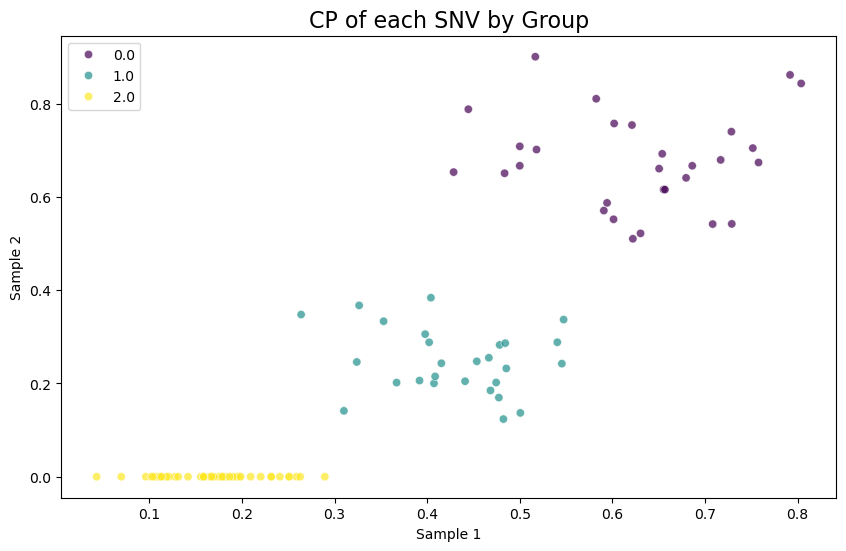

In [3]:
from helper import *
df = pd.read_csv("simulation_data_cluster_3_region_2_read_depth_100_replica_2.tsv", sep="\t")
m = len(np.unique(df['region']))
n = int(len(df) / m)
c_mat = get_c_mat(df)
cparr = np.zeros([n, m])
group = np.zeros(n)
cp = df['tumour_purity'] * df['alt_counts'] * (df['tumour_purity'] * (df['major_cn'] + df['minor_cn']) + 2 * (1 - df['tumour_purity'])) / ((df['ref_counts'] + df['alt_counts']) * df['tumour_purity'] * df['multiplicity'])

for i in range(n):
    group[i] = int(df['cluster'][i * m])
    for j in range(m):
        cparr[i, j] = cp[i * m + j]
plt.figure(figsize=(10, 6))
sns.scatterplot(x=cparr[:, 0], y=cparr[:, 1], hue=group, palette='viridis', alpha=0.7)

# Add labels and title
plt.title("CP of each SNV by Group", fontsize=16)
plt.xlabel("Sample 1")
plt.ylabel("Sample 2")

# Show the plot
plt.show()

In [6]:
from snv import *
import pandas as pd
df = pd.read_csv("simulation_data_cluster_3_region_2_read_depth_100_replica_2.tsv", sep="\t")
m = len(np.unique(df['region']))
n = int(len(df) / m)
rho = 0.2
omega = 1
max_iteration = 20
gamma = [0.1+ 0.002 * i for i in range(14)]
ray.shutdown()
ray.init()
res = [ADMM.remote(df, rho, gamma[i], omega, n, m, max_iteration) for i in range(len(gamma))]
res = ray.get(res)
ray.shutdown()


2025-01-08 14:06:20,672	INFO worker.py:1786 -- Started a local Ray instance.


(ADMM pid=32808) Gamma: 0.10400000000000001, clusters : dict_values([0, 1, 2, 0, 1, 5, 1, 1, 0, 0, 1, 11, 0, 13, 14, 1, 1, 17, 18, 17, 0, 21, 0, 5, 5, 21, 14, 27, 0, 14, 30, 30, 17, 17, 1, 0, 14, 0, 0, 39, 30, 41, 17, 0, 17, 0, 30, 14, 48, 14, 50, 0, 13, 0, 54, 17, 0, 57, 1, 59, 0, 13, 17, 17, 57, 65, 30, 0, 1, 17, 0, 17, 17, 0, 30, 1, 21, 39, 0, 13, 17, 17, 1, 0, 17, 0, 86, 17, 13, 0, 0, 13, 0, 57, 17, 41, 57, 0, 0, 17])
(ADMM pid=32806) Gamma: 0.1, clusters : dict_values([0, 1, 2, 0, 4, 5, 4, 1, 0, 0, 1, 11, 0, 13, 14, 1, 1, 17, 18, 17, 0, 21, 0, 5, 5, 21, 26, 27, 0, 14, 30, 30, 17, 17, 1, 0, 14, 0, 0, 39, 30, 41, 17, 0, 17, 0, 30, 14, 48, 14, 50, 0, 13, 0, 54, 17, 0, 57, 1, 59, 0, 17, 17, 17, 57, 65, 30, 0, 1, 17, 0, 17, 17, 0, 30, 1, 21, 39, 0, 13, 17, 17, 1, 0, 17, 0, 86, 17, 17, 0, 0, 13, 0, 57, 17, 41, 57, 0, 0, 17]) [repeated 12x across cluster]


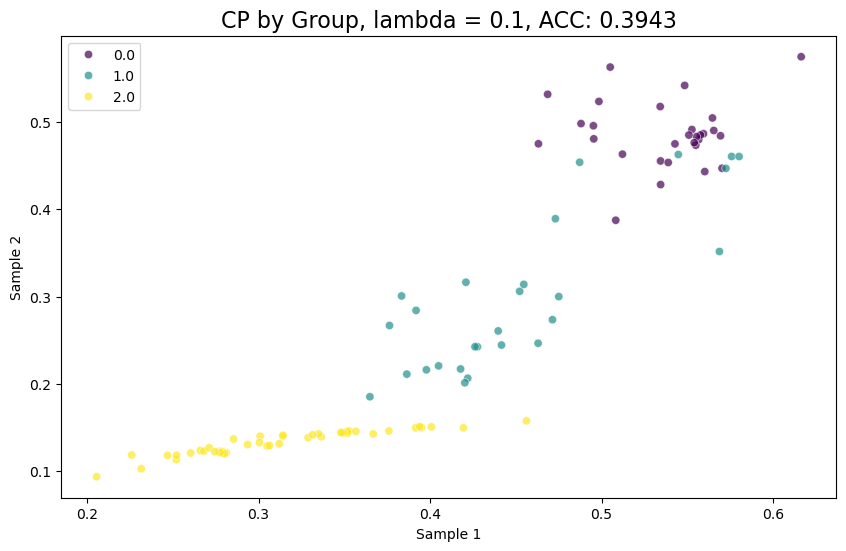

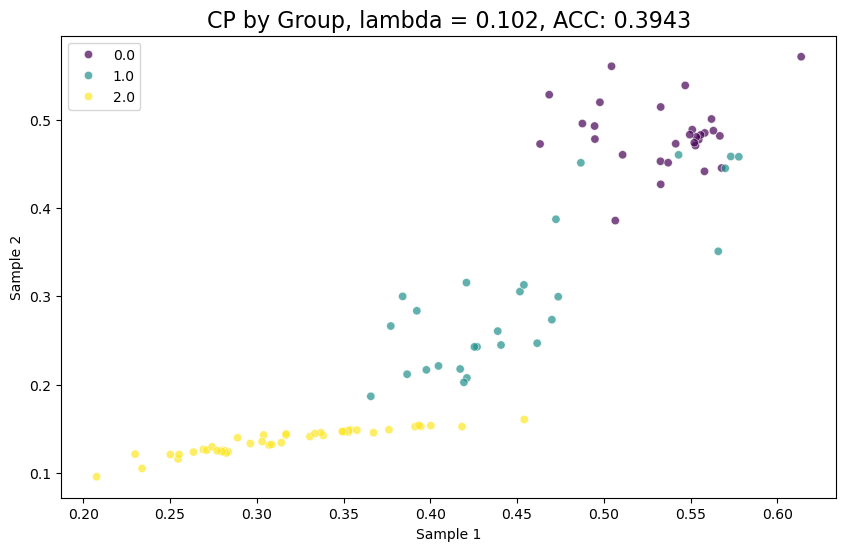

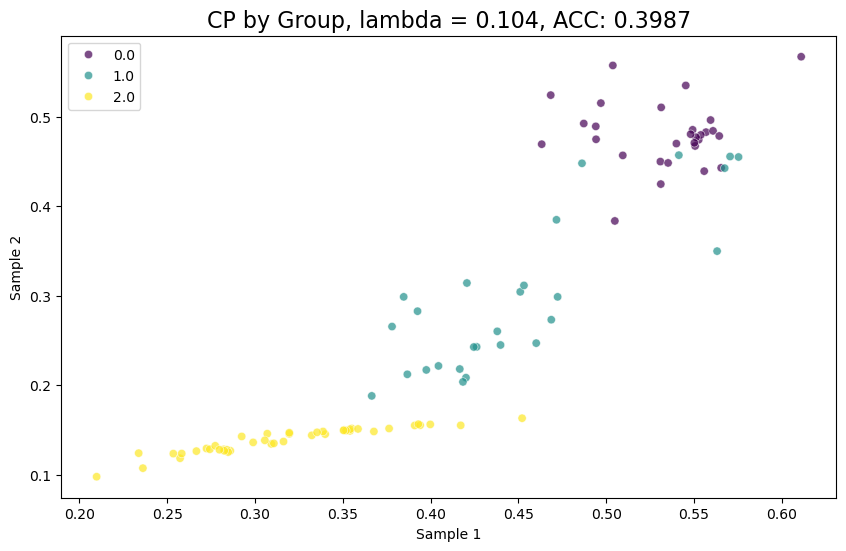

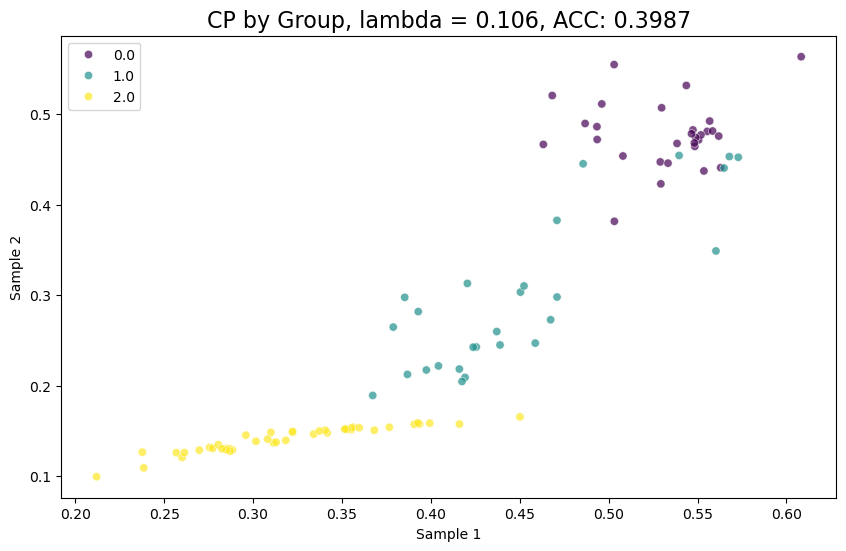

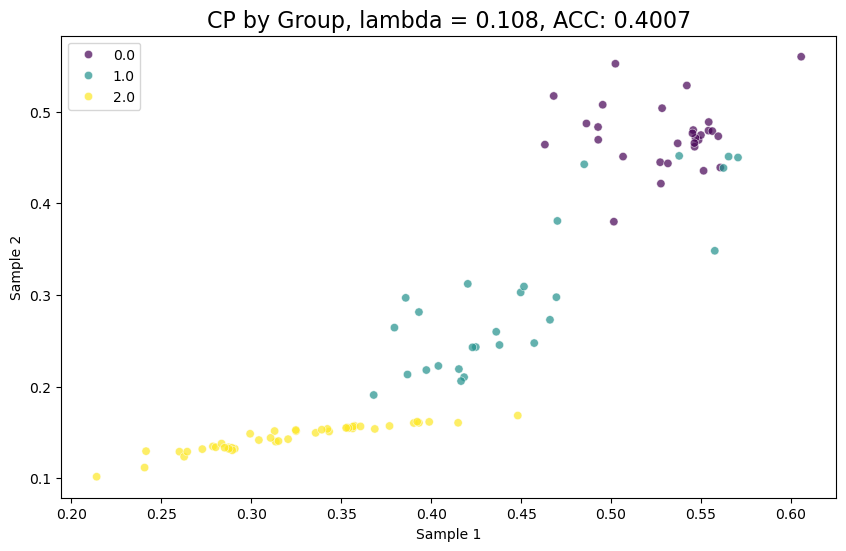

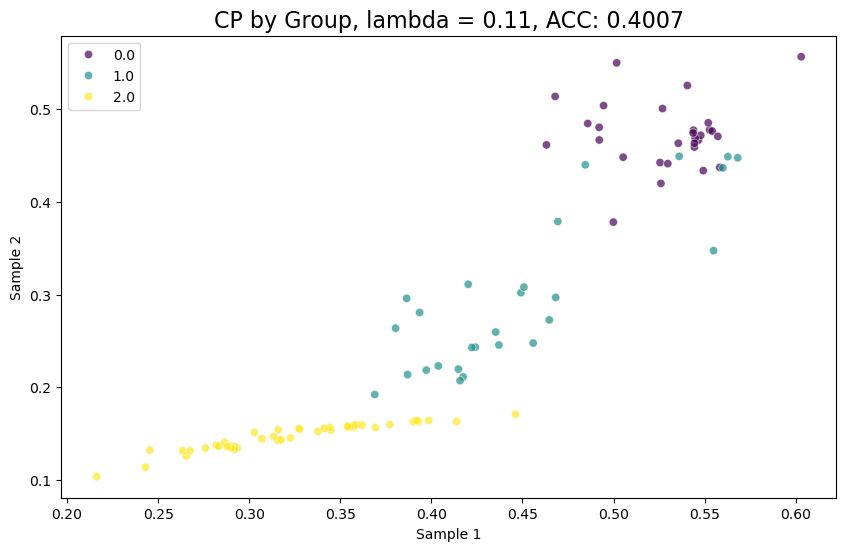

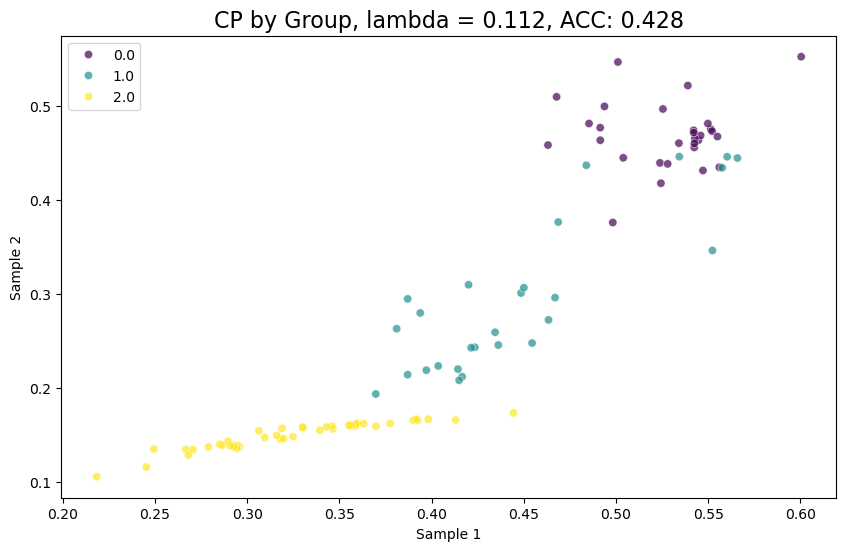

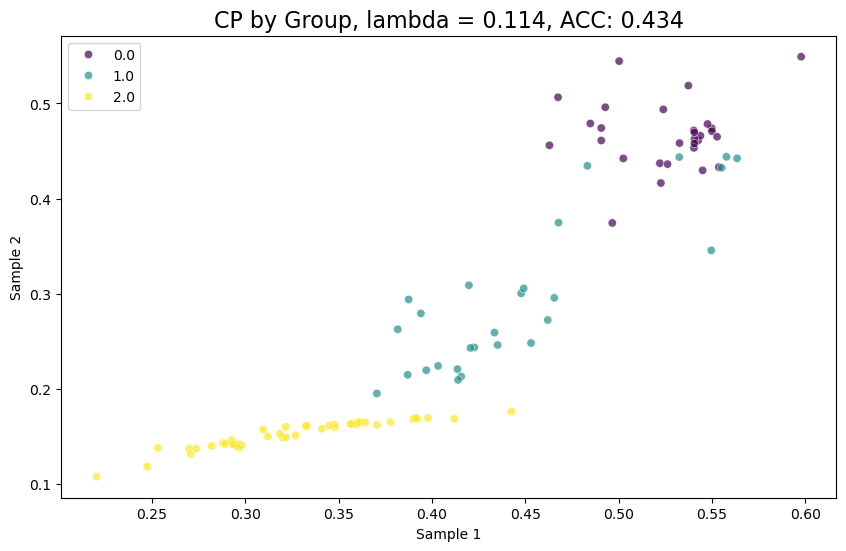

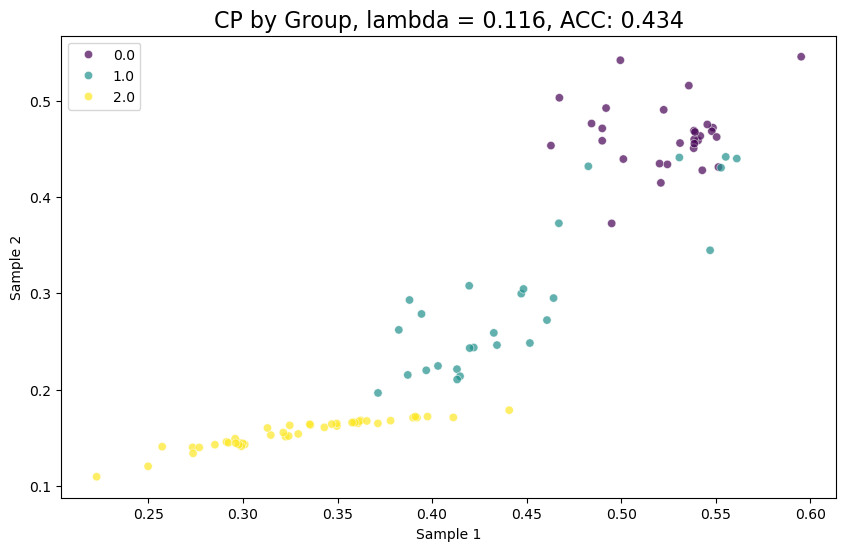

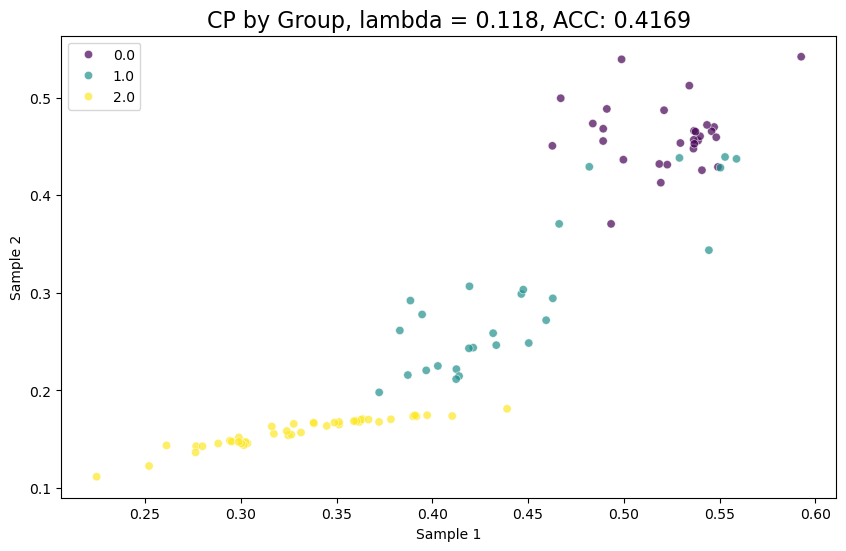

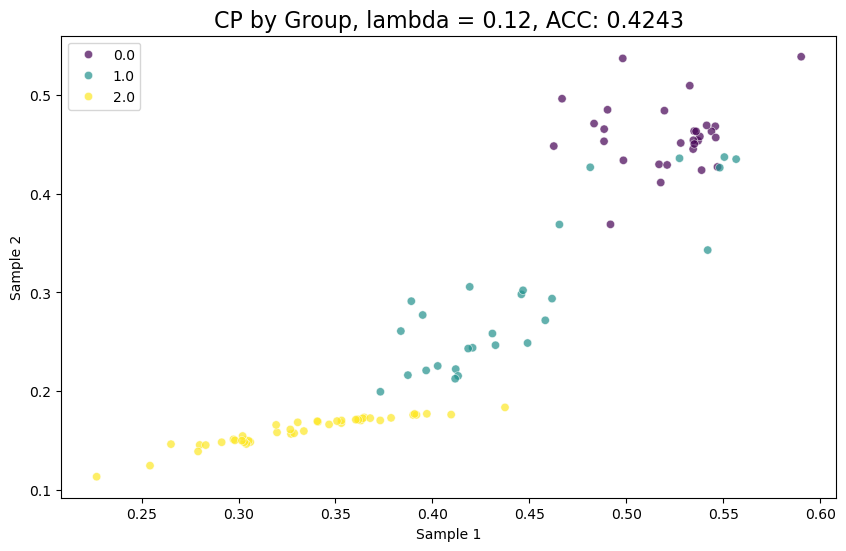

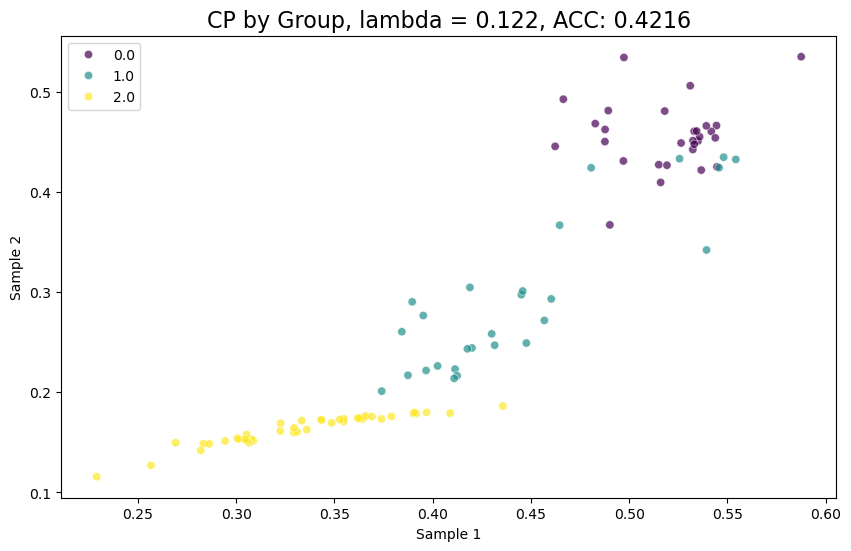

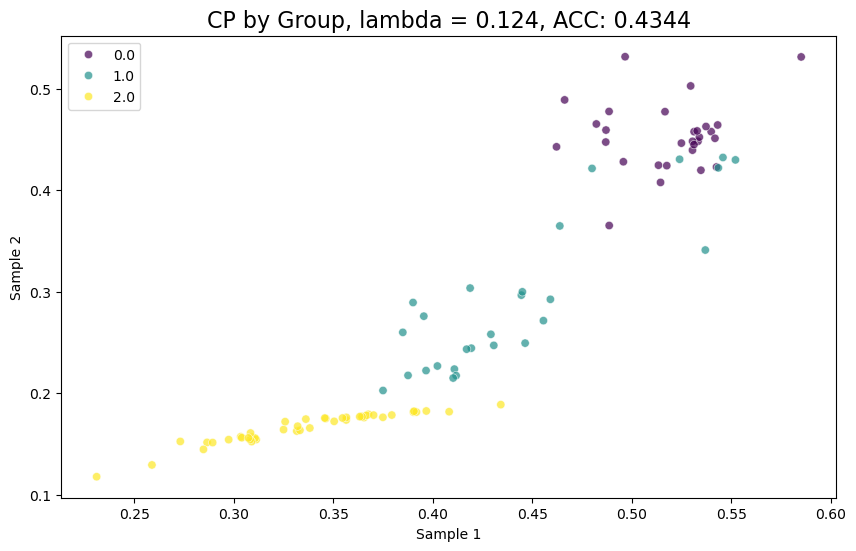

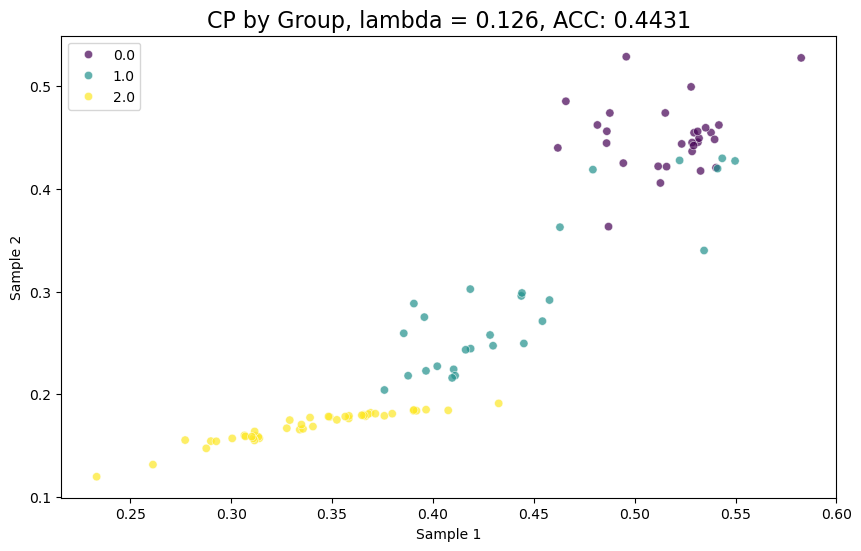

In [7]:
from helper import *
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, rand_score
group = np.zeros(n)
for i in range(n):
    group[i] = int(df['cluster'][i * m])
for i in range(len(gamma)):
    cp = convert_p_to_cp(res[i][0], n, m)
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=cp[:, 0], y=cp[:, 1], hue=group, palette='viridis', alpha=0.7)

    # Add labels and title
    plt.title(f"CP by Group, lambda = {round(gamma[i], 4)}, ACC: {round(adjusted_rand_score(res[i][7], group), 4)}", fontsize=16)
    plt.xlabel("Sample 1")
    plt.ylabel("Sample 2")

    # Show the plot
    # plt.savefig(f"example_{i}.png", dpi=300, bbox_inches="tight")

In [ ]:
import pandas as pd
import glob
import shutil
import numpy as np
from sklearn.decomposition import DictionaryLearning
from sklearn.cluster import KMeans
from sklearn.metrics import rand_score, adjusted_rand_score

def get_clipp_acc(datafile):

   df = pd.read_csv(datafile, sep='\t')
   dfs_by_region = {region: data for region, data in df.groupby('region')}
   n = int(len(df) / len(dfs_by_region))
    # Create an empty matrix of zeros
   matrix = np.zeros((n, n), dtype=int)
    # Assuming dfs_by_region is already defined and contains the DataFrame split by region
   df = pd.read_csv(datafile, sep='\t')
   dfs_by_region = {region: data for region, data in df.groupby('region')}

   df = dfs_by_region['R1']

   # Create df1 with mutation, ref_counts, and alt_counts
   df1 = df[['mutation', 'ref_counts', 'alt_counts']].copy()
   df1['alt_counts'] = df1['alt_counts'].replace(0, 1)
   df1['mutation'] = [1 for i in range(1, len(df1) + 1)]
   df1.rename(columns={
      'ref_counts': 'ref_count',
      'alt_counts': 'alt_count'
   }, inplace=True)
   df1.rename(columns={'mutation': 'chromosome_index'}, inplace=True)
   df1['position'] = [5 * i + 2 for i in range(1, len(df1) + 1)]
   df1 = df1[['chromosome_index', 'position', 'alt_count', 'ref_count']]
   df1.to_csv('sample_snv.txt', sep='\t', index=False)

   # Create df2 with mutation, major_cn, minor_cn, and sum_cn
   df2 = df[['mutation', 'major_cn', 'minor_cn']].copy()
   df2['mutation'] =[1 for i in range(1, len(df2) + 1)]
   df2['total_cn'] = df2['major_cn'] + df2['minor_cn']
   df2.rename(columns={'mutation': 'chromosome_index'}, inplace=True)
   df2['start_position'] = [5 * i + 1 for i in range(1, len(df2) + 1)]
   df2['end_position'] = [5 * i + 4 for i in range(1, len(df2) + 1)]
   df2 = df2[['chromosome_index', 'start_position', 'end_position', 'major_cn', 'minor_cn', 'total_cn']]

   df2.to_csv('sample_cna.txt', sep='\t', index=False)

   # Get the first element of the 'tumour_purity' column
   purity = df['tumour_purity'].iloc[0]

   # Open a file in write mode and save the number
   with open('sample_purity.txt', 'w') as file:
      file.write(str(purity))
      
   !docker run -v $(pwd):/Sample clipp python3 /CliPP/run_clipp_main.py -i /Sample/test /Sample/sample_snv.txt /Sample/sample_cna.txt /Sample/sample_purity.txt

   file = glob.glob('test/final_result/Best_lambda/*mutation_assignments*')
   df = pd.read_csv(file[0], sep='\t')
   cluster_index = df['cluster_index'].values

   # Fill the matrix
   for i in range(n):
      for j in range(n):
         if cluster_index[i] == cluster_index[j]:
               matrix[i, j] += 1
   shutil.rmtree('test')
   
   
   # Assuming dfs_by_region is already defined and contains the DataFrame split by region
   df = pd.read_csv(datafile, sep='\t')
   dfs_by_region = {region: data for region, data in df.groupby('region')}

   df = dfs_by_region['R2']

   # Create df1 with mutation, ref_counts, and alt_counts
   df1 = df[['mutation', 'ref_counts', 'alt_counts']].copy()
   df1['alt_counts'] = df1['alt_counts'].replace(0, 1)
   df1['mutation'] = [1 for i in range(1, len(df1) + 1)]
   df1.rename(columns={
      'ref_counts': 'ref_count',
      'alt_counts': 'alt_count'
   }, inplace=True)
   df1.rename(columns={'mutation': 'chromosome_index'}, inplace=True)
   df1['position'] = [5 * i + 2 for i in range(1, len(df1) + 1)]
   df1 = df1[['chromosome_index', 'position', 'alt_count', 'ref_count']]
   df1.to_csv('sample_snv.txt', sep='\t', index=False)

   # Create df2 with mutation, major_cn, minor_cn, and sum_cn
   df2 = df[['mutation', 'major_cn', 'minor_cn']].copy()
   df2['mutation'] =[1 for i in range(1, len(df2) + 1)]
   df2['total_cn'] = df2['major_cn'] + df2['minor_cn']
   df2.rename(columns={'mutation': 'chromosome_index'}, inplace=True)
   df2['start_position'] = [5 * i + 1 for i in range(1, len(df2) + 1)]
   df2['end_position'] = [5 * i + 4 for i in range(1, len(df2) + 1)]
   df2 = df2[['chromosome_index', 'start_position', 'end_position', 'major_cn', 'minor_cn', 'total_cn']]

   df2.to_csv('sample_cna.txt', sep='\t', index=False)

   # Get the first element of the 'tumour_purity' column
   purity = df['tumour_purity'].iloc[0]

   # Open a file in write mode and save the number
   with open('sample_purity.txt', 'w') as file:
      file.write(str(purity))
      
   !docker run -v $(pwd):/Sample clipp python3 /CliPP/run_clipp_main.py -i /Sample/test /Sample/sample_snv.txt /Sample/sample_cna.txt /Sample/sample_purity.txt

   file = glob.glob('test/final_result/Best_lambda/*mutation_assignments*')
   df = pd.read_csv(file[0], sep='\t')
   cluster_index = df['cluster_index'].values

   # Fill the matrix
   for i in range(n):
      for j in range(n):
         if cluster_index[i] == cluster_index[j]:
               matrix[i, j] += 1
   shutil.rmtree('test')
   
   matrix = matrix / 2
   
   n_components_values = range(1, 21)

   # Regularization parameter for sparsity
   alpha = 1.0

   # Initialize variables to store the best results
   best_n_components = None
   best_reconstruction_error = np.inf
   best_A = None
   best_D = None

   # Perform dictionary learning for different values of n_components
   reconstruction_errors = []
   for n_components in n_components_values:
      dict_learner = DictionaryLearning(n_components=n_components, alpha=alpha, fit_algorithm='lars', transform_algorithm='lars')
      A = dict_learner.fit_transform(matrix)  # Sparse code matrix
      D = dict_learner.components_            # Dictionary matrix
      
      # Calculate the reconstruction error
      reconstruction = np.dot(A, D)
      reconstruction_error = np.linalg.norm(matrix - reconstruction)
      reconstruction_errors.append(reconstruction_error)
      
      # Check if this is the best result so far
      if reconstruction_error < best_reconstruction_error:
         best_n_components = n_components
         best_reconstruction_error = reconstruction_error
         best_A = A
         best_D = D
         
   A = best_A
   
   k_values = range(2, 11)

   # Initialize variables to store the best results
   best_k = None
   best_inertia = np.inf
   best_labels = None
   best_centers = None

   # Perform k-means clustering for different values of k
   for k in k_values:
      kmeans = KMeans(n_clusters=k, random_state=0).fit(A)
      inertia = kmeans.inertia_
      
      # Check if this is the best result so far
      if inertia < best_inertia:
         best_k = k
         best_inertia = inertia
         best_labels = kmeans.labels_
         best_centers = kmeans.cluster_centers_
   
   df = pd.read_csv(datafile, sep='\t')
   m = len(np.unique(df['region']))
   n = int(len(df) / m)
   group = np.zeros(n)
   for i in range(n):
      group[i] = int(df['cluster'][i * m])
   acc = adjusted_rand_score(group, best_labels)
   return acc

In [ ]:
!python clipp_data_simulation.py
datafile = 'multi_clipp_simulation_data/simulation_data_cluster_5_region_2_read_depth_100_replica_2.tsv'
df = pd.read_csv(datafile, sep="\t")
from snv import *
import pandas as pd
from helper import *
df = pd.read_csv(datafile, sep="\t")
m = len(np.unique(df['region']))
n = int(len(df) / m)
rho = 0.2
omega = 1
max_iteration = 20
gamma = [0.05 + 0.002 * i for i in range(56)]
ray.shutdown()
ray.init
res = [ADMM.remote(df, rho, gamma[i], omega, n, m, max_iteration) for i in range(len(gamma))]
res = ray.get(res)
ray.shutdown()

